# Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: House Prices

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

- Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
- Please follow the example above and call engine.dispose() when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
- Investigate the data, and do any necessary data cleaning.
- Explore the data and find some variables that you think would be useful in predicting house prices.
- Build your initial model using these features and estimate the parameters using OLS.
Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at this example solution.

In [19]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [15]:
# get rid of the columns with nan. (since we don't need that many features)
df_drop = df.copy()
for col in df_drop.columns:
    if df_drop[col].isna().any():
#         print(col)
        df_drop = df_drop.drop(columns=col)


# Preliminary data exploration

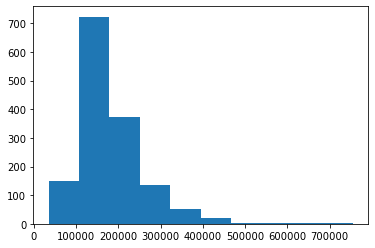

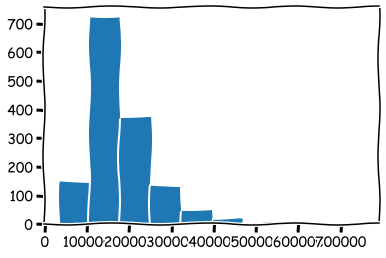

In [18]:
# plot target variable distribution
# target variable "saleprice"

plt.hist(df_drop.saleprice)
plt.show()

# I really like this xkcd style, cool for illustration.
# with plt.xkcd():
#     plt.hist(df_drop.saleprice)
# plt.show()

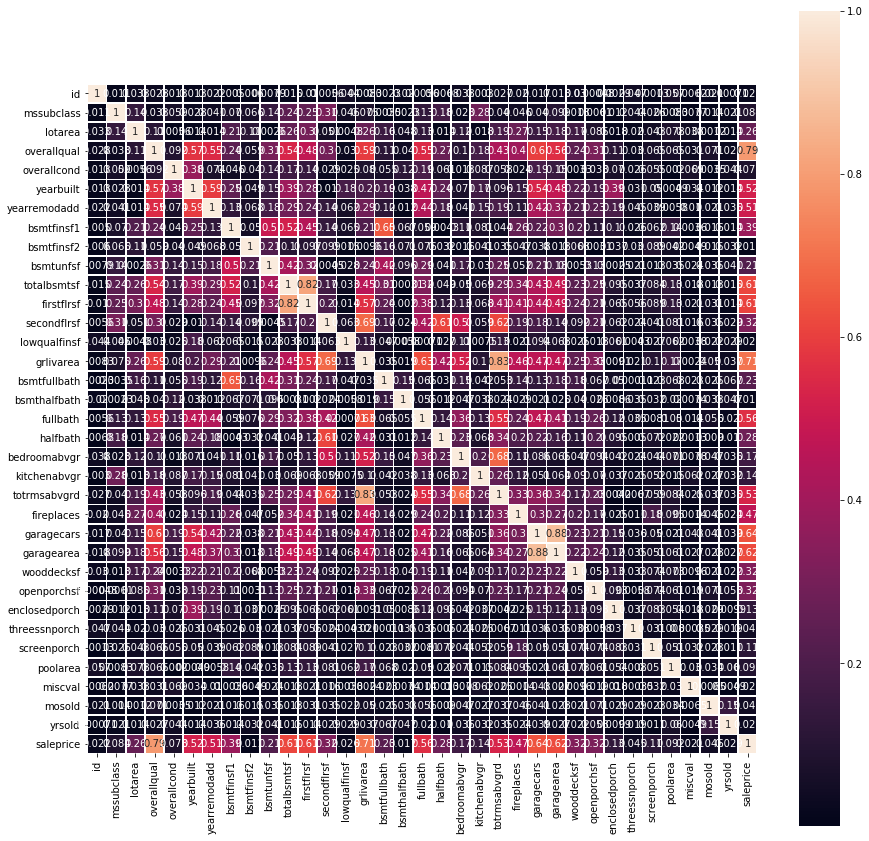

In [22]:
# corr_matrix = 
plt.figure(figsize=(15,15))
sns.heatmap(np.abs(df_drop.corr()), square=True, annot=True, linewidths=.5)
plt.show()

In [38]:
# in this practice, let's just take two categorical variables, I picked "street", "lotshape"
# Encode character string categorical data into numeric data using one hot encoding
df_encoded = pd.concat([df_drop, pd.get_dummies(df_drop["street"], drop_first=True)], axis=1)
df_encoded = pd.concat([df_encoded, pd.get_dummies(df_encoded["lotshape"], drop_first=True)], axis=1)



1073

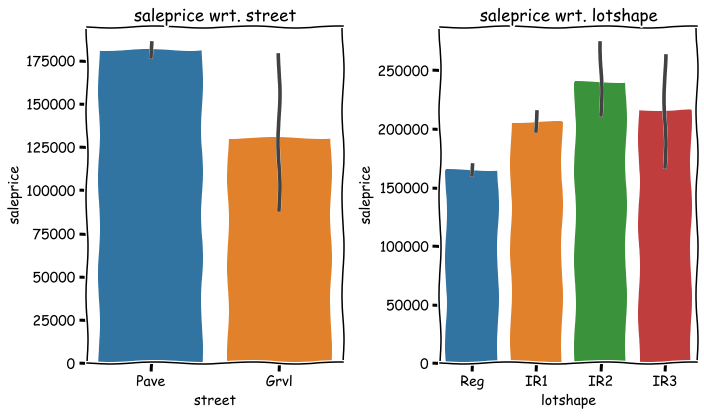

In [46]:
# barplot to show saleprice in the subclass we care, i.e. street, lotshape

with plt.xkcd():
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.barplot(x="street", y="saleprice", data=df_encoded[["street","saleprice"]])
    
    plt.title("saleprice wrt. street")
    plt.ylabel("saleprice")
    plt.xlabel("street")
#     plt.xticks([0,1])

    plt.subplot(1,2,2)
    sns.barplot(x="lotshape", y="saleprice", data=df_encoded[["lotshape","saleprice"]])
    
    
    plt.title("saleprice wrt. lotshape")
    plt.ylabel("saleprice")
    plt.xlabel("lotshape")
#     plt.xticks([0,1])

    plt.tight_layout()
    
    plt.show()

# Modeling the insurance charges with linear regression

In [48]:
# use scikit-learn

# Y is the target variable
Y = df_encoded['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df_encoded[['Pave','IR2', 'IR3', 'Reg']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 54364.99533497  34945.35168985   9822.51034022 -41224.07940969]

Intercept: 
 151848.99432481558


In [49]:
# using statsmodels
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     30.90
Date:                Sat, 01 Feb 2020   Prob (F-statistic):           1.01e-24
Time:                        11:59:08   Log-Likelihood:                -18485.
No. Observations:                1460   AIC:                         3.698e+04
Df Residuals:                    1455   BIC:                         3.701e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.518e+05   3.14e+04      4.833      0.000    9.02e+04    2.13e+05
Pave        5.436e+04   3.13e+04      1.737      0.083   -7021.096    1.16e+05
IR2         3.495e+04   1.24e+04      2.809      0.005    1.05e+04    5.94e+04
IR3         9822.5103   2.44e+04      0.403      0.687    -3.8e+04    5.77e+04
Reg        -4.122e+04   4285.168     -9.620      0.000   -4.96e+04   -3.28e+04
==============================================================================
Omnibus:                      620.430   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3585.674
Skew:                           1.906   Prob(JB):                         0.00
Kurtosis:                       9.664   Cond. No.                         34.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""